# Satellite navigation disturbances in Finland

In [2]:
%pip install lxml

Note: you may need to restart the kernel to use updated packages.


required on Codespaces for pd.read_html()

In [58]:
%pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 54.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import datetime as dt
import geopandas
import matplotlib.pyplot as plt


In [16]:
url='situational-picture-disturbances-satellite-navigation-finland-2024'
(pd
 .read_html('https://www.traficom.fi/en/news/'+url)
 [0]
 .to_csv('finland_disturbance.csv',index=False)
)

Save data locally to avoid webscraping everytime I rerun the notebook.

In [2]:
fi_data=pd.read_csv('finland_disturbance.csv',header=1)

In [3]:
fi_data

,Year,Finland,Finnish operators’ notifications outside of Finland
0,2018,0,6
1,2019,8,137
2,2020,27,34
3,2021,8,71
4,2022,65,1331
5,2023,239,7370
6,2024 (by 30 April),Around 1200,Around 2100


Unfortunately the last line is not purely numeric and needs some cleanup.

In [4]:
def parse_date(input_str):
    return dt.datetime.strptime(input_str,'%d %B %Y')
def clean_table(df):
    return df.assign(
        disturbance_year=fi_data
        .Year.str.split(' ',expand=True)[0].astype('int32'),
        disturbance_y_minus1=fi_data
        .Year.str.split(' ',expand=True)[0].astype('int32')-1,
        end_date =(fi_data
        .Year.str.split('by ',expand=True)[1].str.rstrip(')').fillna('31 December')+' '+fi_data
        .Year.str.split(' ',expand=True)[0]).apply(parse_date).dt.dayofyear,
        disturbances_Finland=fi_data
        .Finland.str.replace('Around ','').astype('int32'),
        disturbances_Outside=fi_data
        ['Finnish operators’ notifications outside of Finland']
        .str.replace('Around ','').astype('int32'),
        disturbances_Finland_weighted=fi_data
        .Finland.str.replace('Around ','').astype('int32')*365/(fi_data
        .Year.str.split('by ',expand=True)[1].str.rstrip(')').fillna('31 December')+' '+fi_data
        .Year.str.split(' ',expand=True)[0]).apply(parse_date).dt.dayofyear
        )

In [5]:
print(dt.datetime.strptime('30 April 2024','%d %B %Y'))

2024-04-30 00:00:00


In [6]:
print(parse_date('30 April 2024'))

2024-04-30 00:00:00


array([<Axes: xlabel='disturbance_year'>,
       <Axes: xlabel='disturbance_year'>], dtype=object)

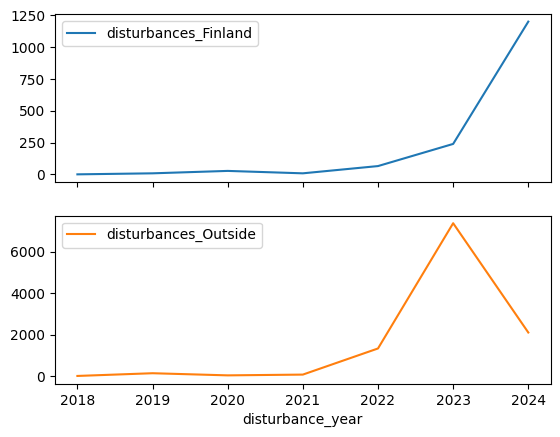

In [7]:
(fi_data
 .pipe(clean_table)
 .set_index('disturbance_year')
 [['disturbances_Finland','disturbances_Outside']]
 .plot(subplots=True)
)

In [8]:
(fi_data
 .pipe(clean_table)
 .set_index('disturbance_year')[['disturbances_Finland','disturbances_Outside']]
 .corr(numeric_only=True)
)

,disturbances_Finland,disturbances_Outside
disturbances_Finland,1.000000,0.272785
disturbances_Outside,0.272785,1.000000


In [9]:
(fi_data
 .pipe(clean_table)
)

,Year,Finland,Finnish operators’ notifications outside of Finland,disturbance_year,disturbance_y_minus1,end_date,disturbances_Finland,disturbances_Outside,disturbances_Finland_weighted
0,2018,0,6,2018,2017,365,0,6,0.000000
1,2019,8,137,2019,2018,365,8,137,8.000000
2,2020,27,34,2020,2019,366,27,34,26.926230
3,2021,8,71,2021,2020,365,8,71,8.000000
4,2022,65,1331,2022,2021,365,65,1331,65.000000
5,2023,239,7370,2023,2022,365,239,7370,239.000000
6,2024 (by 30 April),Around 1200,Around 2100,2024,2023,121,1200,2100,3619.834711


Note we do want to normalise leap years! But it won't make a big difference, unlike the incomplete 2024.

In [10]:
(fi_data
 .pipe(clean_table)
 .set_index('disturbance_y_minus1')[['disturbances_Finland_weighted']]
 .merge(fi_data
        .pipe(clean_table)
        .set_index('disturbance_year')[['disturbances_Outside']],left_index=True, right_index=True)
 .corr()
)

,disturbances_Finland_weighted,disturbances_Outside
disturbances_Finland_weighted,1.000000,0.993154
disturbances_Outside,0.993154,1.000000


array([<Axes: >, <Axes: >], dtype=object)

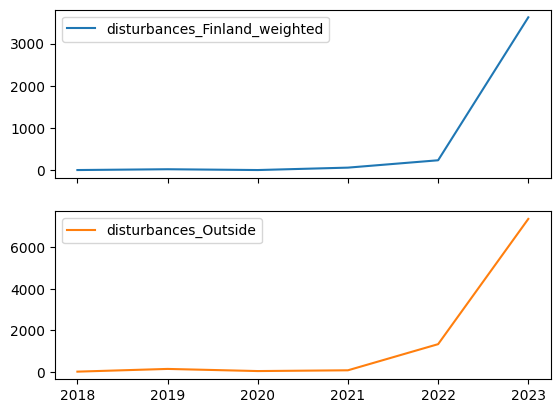

In [11]:
(fi_data
 .pipe(clean_table)
 .set_index('disturbance_y_minus1')[['disturbances_Finland_weighted']]
 .merge(fi_data
        .pipe(clean_table)
        .set_index('disturbance_year')[['disturbances_Outside']],left_index=True, right_index=True)
 .plot(subplots=True)
)

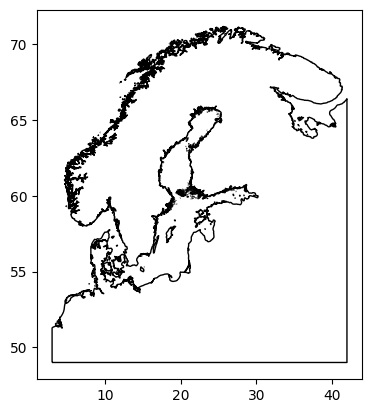

In [21]:
world = geopandas.read_file("https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip")
ax = world.clip([3, 49, 42, 72]).plot(color="white", edgecolor="black")

plt.show()